In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
if False:
    os.environ['MKL_NUM_THREADS'] = "1"
    os.environ['NUMEXPR_NUM_THREADS'] = "1"
    os.environ['OMP_NUM_THREADS'] = "1"
    os.environ['OPENBLAS_NUM_THREADS'] = "1"
    os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import healpy as hp
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [3]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = cy.utils.ensure_dir('/home/ssclafani/public_html/DNNC/paperplots/Fig1')
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [4]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [5]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [6]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [7]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [8]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Helpers

In [9]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    if hasattr(bg, 'pdf'):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit = label_fit.format(bg.ndof, bg.eta)
        if density:
            ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
        else:
            ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Setup Analysis

In [10]:
import sys
sys.path.insert(0, '../..')

import config as cg

cg.base_dir = '/data/user/mhuennefeld/data/analyses/unblinding_v1.0.0/'

Running as User: ssclafani on Hostname: cobalt05.icecube.wisc.edu


In [11]:
def get_gp_tr(template_str, cutoff=np.inf, gamma=None, cpus=20):
    cutoff_GeV = cutoff * 1e3
    gp_conf = cg.get_gp_conf(
        template_str=template_str, gamma=gamma, cutoff_GeV=cutoff_GeV, base_dir=cg.base_dir)
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr

def get_template_tr(template, gamma=2.7, cutoff_tev=np.inf, cpus=20):
    cutoff_gev = cutoff_tev * 1000.
    gp_conf = {
        'template': template,
        'flux': cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff_gev),
        'randomize': ['ra'],
        'fitter_args': dict(gamma=gamma),
        'sigsub': True,
        'update_bg': True,
        'fast_weight': False,
    }
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr


#### Get TrialRunners

In [12]:
tr_dict = {
    'pi0': get_gp_tr('pi0'),
    'kra5': get_gp_tr('kra5'),
    'kra50': get_gp_tr('kra50'),
}

Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/pi0/gamma/2.700/DNNCascade_10yr.template.npy    
Restore successful.
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_5PeV_maps_energies.tuple.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/kra5/DNNCascade_10yr.template.npy    
Restore successful.
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_maps_energies.tuple.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/kra50/DNNCascade_10yr.template.npy    
Restore successful.


#### Get Results for each template

In [13]:
res_dict = {}
for key in tr_dict.keys():
    f_path = os.path.join(
        cg.base_dir, 
        'gp/results/{}/{}_unblinded.npy'.format(key, key), 
    )
    res_dict[key] = np.load(f_path)

#### Print best fit fluxes

In [14]:

dNdE = tr_dict['pi0'].to_dNdE(ns=res_dict['pi0'][1], E0=1e5)
E2dNdE = tr_dict['pi0'].to_E2dNdE(ns=res_dict['pi0'][1], E0=100, unit=1e3)
print(dNdE, E2dNdE)


2.4366279686479028e-18 2.436627968647903e-11


In [15]:
ss_results = np.load(
    os.path.join(
        cg.base_dir, 'skyscan/results/unblinded_skyscan.npy'),
    allow_pickle=True,
)[()]
ss_trial = ss_results['ss_trial']



In [16]:
ss_results


{'ss_trial': array([[0.10876381, 0.10876381, 0.10876381, ..., 0.15437915, 0.15437915,
         0.15437915],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'ipix_max_north': 80365,
 'ipix_max_south': 174637,
 'pval_north': 0.2851425712856428,
 'pval_south': 0.46173086543271635,
 'pval_north_nsigma': 0.5676316041802086,
 'pval_south_nsigma': 0.09607408800677344}

In [17]:
# https://www.nasa.gov/mission_pages/GLAST/news/gammaray_best.html
# https://www.nasa.gov/images/content/317870main_Fermi_3_month_labeled_new.jpg
fermi_sources = {
    # ra, dec
    'NGC 1275': (049.9506656698585, +41.5116983765094),
    '3C 454.3': (343.49061658, +16.14821142),
    '47 Tuc': (006.022329, -72.081444),
    '0FGL J1813.5-1248': (273.349033, -12.766842),
    '0FGL J0614.3-3330': (093.5431162, -33.4983656),
    'PKS 0727-115': (112.57963530917, -11.68683347528),
    'Vela': (128.5000, -45.8333),
    'Geminga': (098.475638, +17.770253),
    'Crab': (083.63308, +22.01450),
    'LSI +61 303': (040.1319341179735, +61.2293308716971),
    'PSR J1836+5925': (279.056921, +59.424936),
    'PKS 1502+106': (226.10408242258, +10.49422183753),
    #'Cygnus X-3': (308.10742, +40.95775),
}

cat_dict = {}
for cat_str in ['pwn', 'snr', 'unid']:
    catalog_file = os.path.join(
        cg.catalog_dir, '{}_ESTES_12.pickle'.format(cat_str))
    cat_dict[cat_str] = np.load(catalog_file, allow_pickle=True)


#### Plot template contours

In [18]:
class ContourSkymap:
    def __init__(self, skymap, nside=None):
        
        # upscale skymap
        if nside is not None:
            skymap = hp.ud_grade(skymap, nside_out=nside)
        else:
            nside = hp.get_nside(skymap)
        
        # normalize such that sum of pixel values equals one
        self.prob_values = skymap / np.sum(skymap)
        self.neg_llh_values = -np.log10(self.prob_values)
        self.nside = hp.get_nside(self.prob_values)
        self.npix = hp.nside2npix(self.nside)
        
        self.theta, self.phi = self.get_healpix_grid()
        
        # sort healpix points according to neg llh
        sorted_indices = np.argsort(self.neg_llh_values)
        self.theta_s = self.theta[sorted_indices]
        self.phi_s = self.phi[sorted_indices]
        self.neg_llh_values_s = self.neg_llh_values[sorted_indices]
        self.prob_values_s = self.prob_values[sorted_indices]
    
        self.cdf_values_s = np.cumsum(self.prob_values_s)
    
    def get_healpix_grid(self):
        npix = hp.nside2npix(self.nside)
        theta, phi = hp.pix2ang(self.nside, np.r_[:npix])
        return theta, phi
    
    def quantile_to_pdf_value(self, quantile):
        """Get pixel probability value
        """
        assert quantile >= 0., quantile
        assert quantile <= 1., quantile

        index = np.searchsorted(self.cdf_values_s, quantile)
        return self.prob_values_s[index]
    
    def _get_level_indices(self, level=0.5, delta=0.01):
        """Get indices of healpix map, which belong to the specified
        contour as defined by: level +- delta.

        Parameters
        ----------
        level : float, optional
            The contour level. Example: a level of 0.7 means that 70% of events
            are within this contour.
        delta : float, optional
            The contour is provided by selecting directions from the sampled
            ones which have cdf values within [level - delta, level + delta].
            The smaller delta, the more accurate the contour will be. However,
            the number of available sample points for the contour will also
            decrease.

        Returns
        -------
        int, int
            The starting and stopping index for a slice of sampled events
            that lie within the contour [level - delta, level + delta].

        Raises
        ------
        ValueError
            If number of resulting samples is too low.
        """
        assert level >= 0., level
        assert level <= 1., level

        index_min = np.searchsorted(self.cdf_values_s, level - delta)
        index_max = min(self.npix,
                        np.searchsorted(self.cdf_values_s, level + delta))

        if index_max - index_min <= 10:
            raise ValueError('Number of samples is too low!')

        return index_min, index_max
    
    def contour(self, level=0.5, delta=0.01):
        """Get zenith/azimuth paris of points that lie with the specified
        contour [level - delta, level + delta].

        Parameters
        ----------
        level : float, optional
            The contour level. Example: a level of 0.7 means that 70% of events
            are within this contour.
        delta : float, optional
            The contour is provided by selecting directions from the sampled
            ones which have cdf values within [level - delta, level + delta].
            The smaller delta, the more accurate the contour will be. However,
            the number of available sample points for the contour will also
            decrease.

        Returns
        -------
        np.array, np.array
            The theta/phi pairs that lie within the contour
            [level - delta, level + delta].
        """
        index_min, index_max = self._get_level_indices(level, delta)
        return (self.theta_s[index_min:index_max],
                self.phi_s[index_min:index_max])

In [19]:
def get_smeared_template(key, smearing=5):
    space_pdf = tr_dict[key].llh_models[0].pdf_ratio_model.models[0]
    sigma_idx = np.searchsorted(np.rad2deg(space_pdf.sigmas), smearing)
    template_smeared = space_pdf.pdf_space_sig[sigma_idx]
    return np.array(template_smeared)


#### Skymap Plotting Class

In [68]:
import utils
sys.path.insert(0, '../unblinding')
import contour_compute


class SkymapPlotter:
    
    def __init__(self, fermi_sources=fermi_sources, cat_dict=cat_dict, ss_results=ss_results, **kwargs):
        self.cat_dict = cat_dict
        self.fermi_sources = fermi_sources
        self.ss_results = ss_results
        self.coord = None
        
        self.fig, self.ax, self.sp, self.cb = self.plot_skymap(**kwargs)
    
    def add_skymap_layer(self, m, ax=None, **kw):
        if ax is None:
            ax = self.ax
        lat, lon, Z = self.sp.map_to_latlonz(m)
        pc = ax.pcolormesh(lon, lat, Z, **kw)
        return pc
        
    @staticmethod
    def plot_skymap(
                skymap, fig=None, ax=None, outfile=None, figsize=(9, 6),
                vmin=None, vmax=None, label=None, norm=None,
                cmap=cy.plotting.skymap_cmap,
                input_coord='C',
                n_cb_ticks=5,
                gp_kw=dict(color='.3', alpha=0.5), gp_lw=1.,
                plot_gp=True, annotate=True,
                **kwargs
            ):
        """Plot a skymap

        Parameters
        ----------
        skymap : array_like
            The skymap to plot.
        outfile : str, optional
            The output file path to which to plot if provided.
        vmin : float, optional
            The minimum value for the colorbar.
        vmax : float, optional
            The maximum value for the colorbar.
        figsize : tuple, optional
            The figure size to use.
        label : str, optional
            The label for the colorbar.

        Returns
        -------
        fig, ax
            The matplotlib figure and axis.
        """
        if fig is None:
            fig, ax = plt.subplots(
                 figsize=figsize)

        if 'coord' in kwargs and kwargs['coord'] == 'G':
            nohr = True
            if input_coord == 'C':
                skymap = SkymapPlotter.equatorial_to_galactic(skymap)
        else:
            nohr = False

        sp = cy.plotting.SkyPlotter(
            pc_kw=dict(cmap=cmap, vmin=vmin, vmax=vmax, norm=norm), 
            **kwargs
        )
        mesh, cb = sp.plot_map(ax, skymap, n_ticks=n_cb_ticks, nohr=nohr, pc_kw={"edgecolor" : 'k', 'linewidth' : 0.0})
        #cb(pad=5)
        SkymapPlotter.annotate_skymap(
            ax=ax, sp=sp, annotate=annotate, plot_gp=plot_gp, gp_kw=gp_kw, gp_lw=gp_lw,
        )
        if False:
            if sp.coord == 'G' and annotate:
                kw = dict(xycoords='axes fraction', textcoords='offset pixels', verticalalignment='center')
                #ax.annotate(r'l = -180°', xy=(1, .5), xytext=(10, 0), horizontalalignment='left', **kw)
                #ax.annotate(r'l = 180°', xy=(0, .5), xytext=(-10, 0), horizontalalignment='right', **kw)

            if sp.coord != 'G' and plot_gp:
                sp.plot_gp(ax, lw=gp_lw, **gp_kw)
                sp.plot_gc(ax, **gp_kw)
            kw = dict(color='.5', alpha=.5)
            #ax.grid(**kw)
        cb.set_label(label)
        
        #print(cb.keys())
        #ax.set_xticks(np.radians([0,90,120,180,270,360]))
        #ax.set_ylim(np.radians(-15), np.radians(15))
        #ax.set_yticks(np.radians([-15,0,15]))
        #fig.tight_layout()
        #if outfile is not None:
        #    fig.savefig(outfile)

        return fig, ax, sp, cb
    
    def get_axs(self):
        return fig, ax
    @staticmethod
    def annotate_skymap(ax, sp, annotate=True, plot_gp=True, gp_kw=dict(color='.3', alpha=0.5), gp_lw=1.):
        if sp.coord == 'G' and annotate:
            kw = dict(xycoords='axes fraction', textcoords='offset pixels', verticalalignment='center')
            #ax.annotate(r'l = -180°', xy=(1, .5-30/180), xytext=(10, 0), horizontalalignment='left', **kw)
            #ax.annotate(r'l = 180°', xy=(0, .5-30/180), xytext=(-10, 0), horizontalalignment='right', **kw)
        
        if sp.coord != 'G' and plot_gp:
            sp.plot_gp(ax, lw=gp_lw, **gp_kw)
            sp.plot_gc(ax, **gp_kw)
        kw = dict(color='.5', alpha=.5)
        ax.grid(**kw)
    
    @staticmethod
    def equatorial_to_galactic(m, rot=180):
        r = hp.Rotator(rot=rot, coord='CG')
        return r.rotate_map_pixel(m)

    @staticmethod
    def equatorial_to_galactic_coords(theta, phi, rot=180):
        r = hp.Rotator(rot=rot, coord='CG')
        return r(theta, phi)
    
    def convert_theta_phi_to_mpl_coords(self, theta, phi, convert=True):
        if self.sp.coord == 'G' and convert:
            theta, phi = self.equatorial_to_galactic_coords(theta, phi)
        x, y = self.sp.thetaphi_to_mpl(theta, phi)
        return x, y
        
    def convert_ra_dec_to_mpl_coords(self, ra, dec):
        theta = np.pi/2. - dec
        phi = ra
        return self.convert_theta_phi_to_mpl_coords(theta=theta, phi=phi)

    def draw_equator(self, ax=None, color='0.6', s=1, **kwargs):
        if ax is None:
            ax = self.ax
        phi = np.linspace(0., 2*np.pi, 10000)
        dec = np.zeros_like(phi)
        x, y = self.convert_ra_dec_to_mpl_coords(ra=phi, dec=dec)
        return ax.scatter(x, y, marker='.', color=color, s=s)

    def plot_catalog(self, ax=None, sp=None, marker='x', color='red'):
        
        if ax is None:
            ax = self.ax
        if sp is None:
            sp = self.sp
            
        for cat_str, cat in self.cat_dict.items():
            x, y = self.convert_ra_dec_to_mpl_coords(
                ra=np.deg2rad(cat.ra_deg), dec=np.deg2rad(cat.dec_deg))
            ax.scatter(x, y, marker=marker, color=color, label=cat_str)
    
    def plot_hotspots(self, ax=None, sp=None, marker='x', color='0.8', **kwargs):
        if ax is None:
            ax = self.ax
        if sp is None:
            sp = self.sp
            
        # plot hottest spots
        for res_str in ['ipix_max_north', 'ipix_max_south']:
            theta, phi = hp.pix2ang(128, self.ss_results[res_str])
            x, y = self.convert_theta_phi_to_mpl_coords(theta=theta, phi=phi)
            ax.scatter(x, y, marker=marker, color=color, **kwargs)
    
    def plot_fermi_sources(self, ax=None, sp=None, marker='+', color='1.0'):
        
        if ax is None:
            ax = self.ax
        if sp is None:
            sp = self.sp
            
        for key, (ra_deg, dec_deg) in self.fermi_sources.items():
            x, y = self.convert_ra_dec_to_mpl_coords(
                ra=np.deg2rad(ra_deg), dec=np.deg2rad(dec_deg))
            ax.scatter(x, y, marker=marker, color=color)
    
    def get_contour(self, skymap, quantiles=[0.5], geodesic='planar'):
        """Get contours

        Returns
        -------
        contours_by_level : list(list(list(point)))
            The contours for each level
            Outermost list indexes by level
            Second list indexes by contours at a particular level
            Third list indexes by points in each contour
            Points are of the same form as sample_points
        """
        nside = hp.get_nside(skymap)
        theta, phi = hp.pix2ang(nside=nside, ipix=np.arange(hp.nside2npix(nside)))
        
        if self.sp.coord == 'G':
            skymap = SkymapPlotter.equatorial_to_galactic(skymap)
        
        # compute PDF levels for provided quantiles 
        contour_map = ContourSkymap(skymap=skymap)

        levels = []
        for quantile in quantiles:
            levels.append(contour_map.quantile_to_pdf_value(quantile))
        
        # compute sample points in which to compute the contours
        if geodesic == 'spherical':
            sample_points = np.stack((theta, phi), axis=1)
        elif geodesic == 'planar':
            x, y = self.convert_theta_phi_to_mpl_coords(theta=theta, phi=phi, convert=False)
            sample_points = np.stack((x, y), axis=1)
        else:
            raise ValueError('Unknown geodesic: {}'.format(geodesic))

        contours = contour_compute.compute_contours(
            sample_points=sample_points, samples=contour_map.prob_values, levels=levels, geodesic=geodesic)
        return contours

    
    def plot_template_contour(
                self, template_str, smearing_deg=5., quantiles=[0.5], ls=['-'], color=[None], geodesic='planar',
        ):
        assert len(quantiles) == len(ls)
        assert len(quantiles) == len(color)
        
        template = get_smeared_template(template_str, smearing=smearing_deg)
        contours = self.get_contour(skymap=template, quantiles=quantiles, geodesic=geodesic)
        for ls_i, color_i, contour in zip(ls, color, contours):
            for contour_i in contour:
                if geodesic == 'spherical':
                    x, y = self.convert_theta_phi_to_mpl_coords(theta=contour_i[:, 0], phi=contour_i[:, 1], convert=False)
                elif geodesic == 'planar':
                    x, y = contour_i[:, 0], contour_i[:, 1]
                else:
                    raise ValueError('Unknown geodesic: {}'.format(geodesic))
                if len(x) > 2:
                    self.ax.plot(x, y, ls=ls_i, color=color_i)
        return contours
    
    def plot_template_contour_points(
                self, template_str, level, 
                smearing_deg=5, color='0.2', delta=0.01, 
                marker='.', s=1,
                ax=None, sp=None,
            ):
        contour_map = ContourSkymap(get_smeared_template(template_str, smearing=smearing_deg))
        theta, phi = contour_map.contour(level=level, delta=delta)
        x, y = self.convert_theta_phi_to_mpl_coords(theta=theta, phi=phi)
        self.ax.scatter(x, y, marker=marker, s=s, color=color)


#### Plot p-value plot

/mnt/lfs7/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)


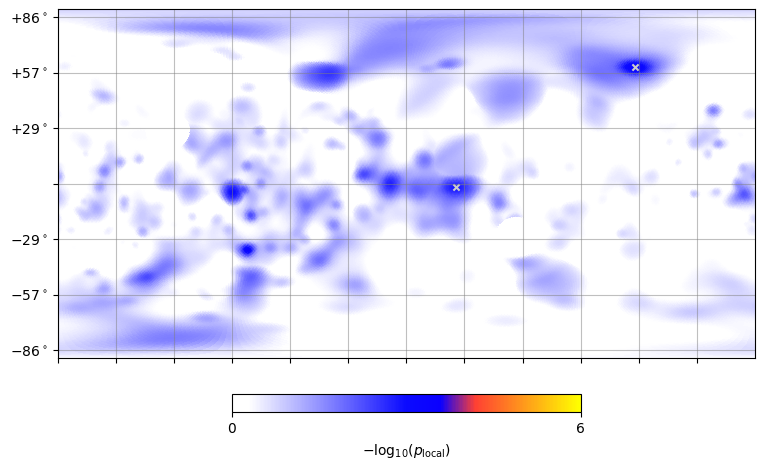

In [21]:
skymap_plotter = SkymapPlotter(
    skymap=ss_trial[0], label=r'$-\log_{10}(p_\mathrm{local})$', vmin=0, vmax=6, coord='G',
    gp_kw=dict(color='0.3', alpha=0.5), n_cb_ticks=2, gp_lw=1.)
#skymap_plotter.plot_catalog(marker='x', color='k')
skymap_plotter.plot_hotspots(marker='x', color='0.8', s=20)
skymap_plotter.fig.savefig('{}/skymap_pvalues.png'.format(plot_dir))


#### Plot N-sigmas

In [22]:
'''from scipy import stats

ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])

min_val = -0.52
mask = ss_nsigmas <= min_val
ss_nsigmas[mask] = min_val

mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots()

skymap_plotter = SkymapPlotter(fig=fig, ax=ax,
    skymap=ss_nsigmas, cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', 
    gp_kw=dict(color='0.3', alpha=0.5), gp_lw=1., cb_kw={'pad':.25}, n_cb_ticks=9)
#skymap_plotter.plot_catalog(marker='x', color='k')
#skymap_plotter.plot_hotspots(marker='x', color='0.8', s=20)
#skymap_plotter.plot_fermi_sources(marker='+', color='green')

smearing_deg = 7
q = 0.2
#skymap_plotter.plot_template_contour('pi0', quantiles=[q], color=['0.2'], ls=['--'], smearing_deg=smearing_deg)
#skymap_plotter.plot_template_contour('kra5', quantiles=[q], color=['green'], ls=['--'], smearing_deg=smearing_deg)
#skymap_plotter.plot_template_contour('pi0', quantiles=[q, 0.5], color=['0.2', '0.5'], ls=['--', '-.'], smearing_deg=smearing_deg)
#skymap_plotter.plot_template_contour_points('pi0', level=q, color='0.2', smearing_deg=smearing_deg, delta=0.007)
#skymap_plotter.plot_template_contour_points('kra5', level=q, color='green', smearing_deg=smearing_deg, delta=0.004)

#skymap_plotter.fig.savefig('{}/skymap_nsigma_s{:1.1f}_q{:1.1f}.png'.format(plot_dir, smearing_deg, q))
skymap_plotter.fig.savefig('{}/skymap_nsigma_.png'.format(plot_dir, smearing_deg, q))
'''

"from scipy import stats\n\nss_nsigmas =  stats.norm.isf(10**-ss_trial[0])\n\nmin_val = -0.52\nmask = ss_nsigmas <= min_val\nss_nsigmas[mask] = min_val\n\nmask_pole = ss_trial[3] == 0.\nss_nsigmas[mask_pole] = np.nan\n\ncmap = plt.cm.RdBu_r  # define the colormap\n# extract all colors from the .jet map\ncmaplist = [cmap(i) for i in range(cmap.N)]\n# force the first color entry to be grey\n#cmaplist[0] = (.5, .5, .5, 1.0)\n\n# create the new map\ncmap = mpl.colors.LinearSegmentedColormap.from_list(\n    'Custom cmap', cmaplist, cmap.N)\n\n# define the bins and normalize\nbounds = np.linspace(-4, 4, 18)\nprint('bounds', bounds)\nnorm = mpl.colors.BoundaryNorm(bounds, cmap.N)\nfig, ax = plt.subplots()\n\nskymap_plotter = SkymapPlotter(fig=fig, ax=ax,\n    skymap=ss_nsigmas, cmap=cmap, norm=norm, label=r'$n\\cdot \\sigma$', \n    gp_kw=dict(color='0.3', alpha=0.5), gp_lw=1., cb_kw={'pad':.25}, n_cb_ticks=9)\n#skymap_plotter.plot_catalog(marker='x', color='k')\n#skymap_plotter.plot_hotspots

In [23]:
import cv2

In [24]:
gp_optical = cv2.imread('images/opt_poster.jpg')
gp_gamma = cv2.imread('images/egret_poster.jpg')
gp_gamma = cv2.cvtColor(gp_gamma, cv2.COLOR_BGR2RGB)

bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/pytho

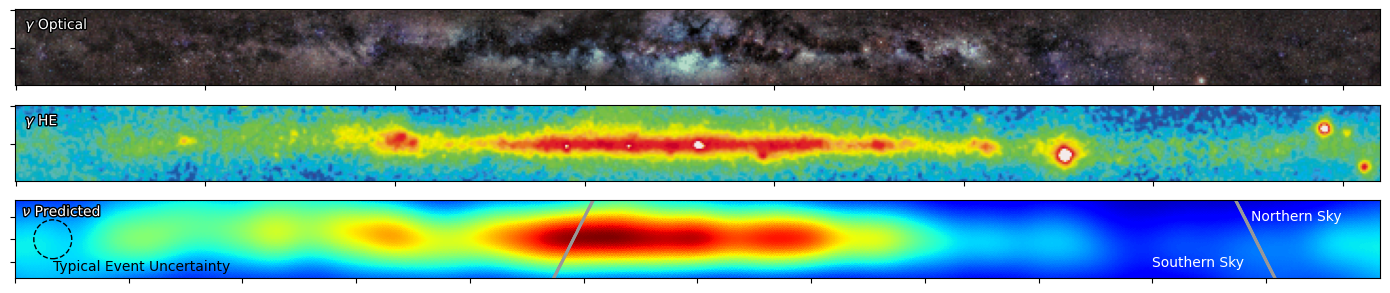

In [25]:
from scipy import stats
import matplotlib.patheffects as PathEffects
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1) = plt.subplots(3,1, figsize=(14,3))

ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])
'''gp_optical_plotter = SkymapPlotter(fig=fig, ax=ax0, 
                               skymap= np.nan*np.zeros_like(ss_nsigmas), cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
ax0.set_yticklabels([0])
gp_optical_plotter.draw_equator()
gp_optical_plotter.cb.remove()'''

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])


'''gp_optical_plotter = SkymapPlotter(fig=fig, ax=ax0, 
                               skymap= np.nan*np.zeros_like(ss_nsigmas), cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
ax0.set_yticklabels([0])
gp_optical_plotter.draw_equator()
gp_optical_plotter.cb.remove()'''

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

#nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
#                               skymap=ss_nsigmas, cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
'''nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
                               skymap=ss_trial[0], cmap=cy.plotting.skymap_cmap, 
                               coord='G', vmin=0, vmax=5)'''
#ax2.set_ylim(np.radians(-10), np.radians(10))
#ax2.set_yticklabels([0])

#nsigma_plotter.draw_equator(color='grey')
#nsigma_plotter.cb.remove()
#ax2.grid(None)

#txt = ax2.text(np.radians(-178), np.radians(6), r'$\nu$ Observed' , color='w', alpha=1, )
#txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'pi0'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1,
    skymap=template, cmap='jet',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='k', fill=False, ls='--')
ax1.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='k')
ax1.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)
plt.tight_layout()
plt.savefig('{}/template_galactic.png'.format(plot_dir))


bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/pytho

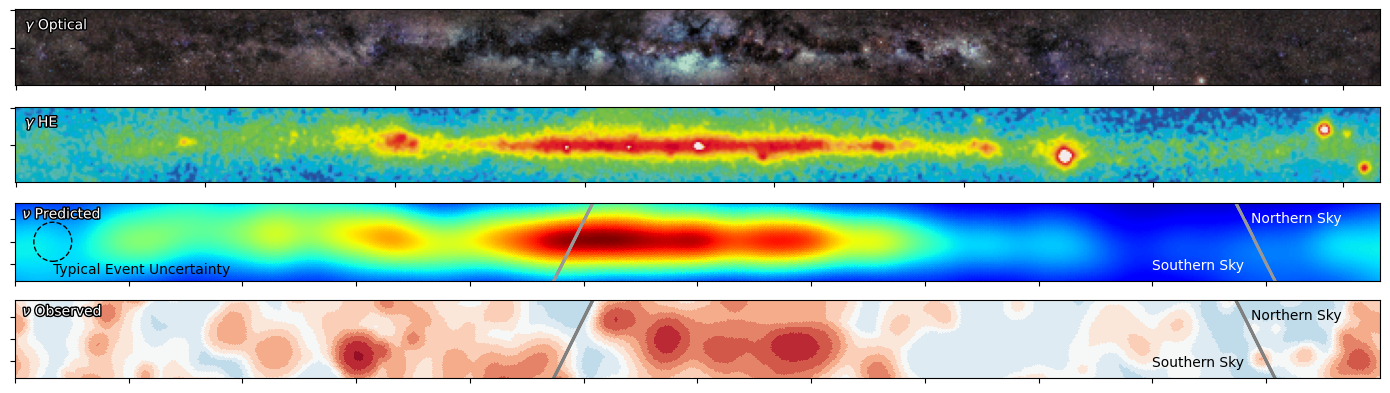

In [26]:
from scipy import stats
import matplotlib.patheffects as PathEffects
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1, ax2) = plt.subplots(4,1, figsize=(14,4))

ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])
'''gp_optical_plotter = SkymapPlotter(fig=fig, ax=ax0, 
                               skymap= np.nan*np.zeros_like(ss_nsigmas), cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
ax0.set_yticklabels([0])
gp_optical_plotter.draw_equator()
gp_optical_plotter.cb.remove()'''

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])


'''gp_optical_plotter = SkymapPlotter(fig=fig, ax=ax0, 
                               skymap= np.nan*np.zeros_like(ss_nsigmas), cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
ax0.set_yticklabels([0])
gp_optical_plotter.draw_equator()
gp_optical_plotter.cb.remove()'''

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
                               skymap=ss_nsigmas, cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
'''nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
                               skymap=ss_trial[0], cmap=cy.plotting.skymap_cmap, 
                               coord='G', vmin=0, vmax=5)'''
ax2.set_ylim(np.radians(-10), np.radians(10))
ax2.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
nsigma_plotter.draw_equator(color='grey')
nsigma_plotter.cb.remove()
ax2.grid(None)

txt = ax2.text(np.radians(-178), np.radians(6), r'$\nu$ Observed' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'pi0'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1,
    skymap=template, cmap='jet',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')
circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='k', fill=False, ls='--')
ax1.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='k')
ax1.add_patch(circle1)
#ax1.text(np.radians(120), np.radians(-5), 'Northern Sky', c='k', rotation=-60, rotation_mode='anchor')
template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)

ax2.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='k' , rotation_mode='default')
ax2.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='k', rotation_mode='default')

plt.tight_layout()
plt.savefig('{}/template_galactic_results.png'.format(plot_dir))
#skymap_plotter.fig.savefig('{}/skymap_nsigma_galactic_s{:1.1f}_q{:1.1f}.png'.format(plot_dir, smearing_deg, q))


bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/pytho

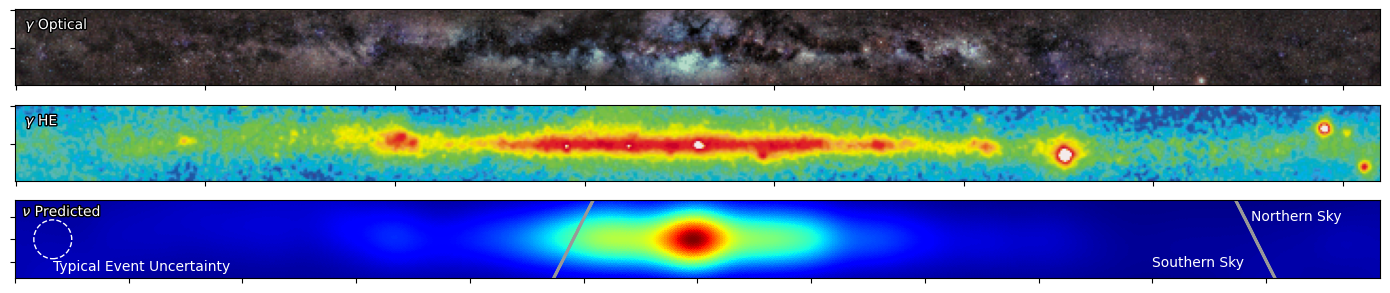

In [27]:
from scipy import stats
import matplotlib.patheffects as PathEffects
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1) = plt.subplots(3,1, figsize=(14,3))

ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])
'''gp_optical_plotter = SkymapPlotter(fig=fig, ax=ax0, 
                               skymap= np.nan*np.zeros_like(ss_nsigmas), cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
ax0.set_yticklabels([0])
gp_optical_plotter.draw_equator()
gp_optical_plotter.cb.remove()'''

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])


'''gp_optical_plotter = SkymapPlotter(fig=fig, ax=ax0, 
                               skymap= np.nan*np.zeros_like(ss_nsigmas), cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
ax0.set_yticklabels([0])
gp_optical_plotter.draw_equator()
gp_optical_plotter.cb.remove()'''

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

#nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
#                               skymap=ss_nsigmas, cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
'''nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
                               skymap=ss_trial[0], cmap=cy.plotting.skymap_cmap, 
                               coord='G', vmin=0, vmax=5)'''
#ax2.set_ylim(np.radians(-10), np.radians(10))
#ax2.set_yticklabels([0])

#nsigma_plotter.draw_equator(color='grey')
#nsigma_plotter.cb.remove()
#ax2.grid(None)

#txt = ax2.text(np.radians(-178), np.radians(6), r'$\nu$ Observed' , color='w', alpha=1, )
#txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'kra5'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1,
    skymap=template, cmap='jet',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax1.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax1.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)
plt.tight_layout()
plt.savefig('{}/template_galactic_kra5.png'.format(plot_dir))


bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/pytho

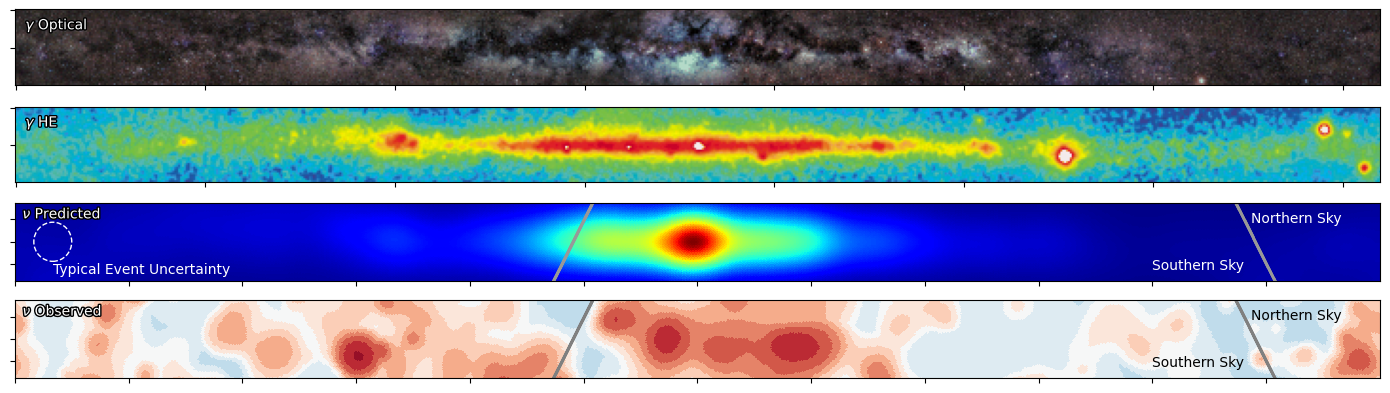

In [28]:
from scipy import stats
import matplotlib.patheffects as PathEffects
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1, ax2) = plt.subplots(4,1, figsize=(14,4))

ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])
'''gp_optical_plotter = SkymapPlotter(fig=fig, ax=ax0, 
                               skymap= np.nan*np.zeros_like(ss_nsigmas), cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
ax0.set_yticklabels([0])
gp_optical_plotter.draw_equator()
gp_optical_plotter.cb.remove()'''

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])


'''gp_optical_plotter = SkymapPlotter(fig=fig, ax=ax0, 
                               skymap= np.nan*np.zeros_like(ss_nsigmas), cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
ax0.set_yticklabels([0])
gp_optical_plotter.draw_equator()
gp_optical_plotter.cb.remove()'''

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
                               skymap=ss_nsigmas, cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
'''nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
                               skymap=ss_trial[0], cmap=cy.plotting.skymap_cmap, 
                               coord='G', vmin=0, vmax=5)'''
ax2.set_ylim(np.radians(-10), np.radians(10))
ax2.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
nsigma_plotter.draw_equator(color='grey')
nsigma_plotter.cb.remove()
ax2.grid(None)

txt = ax2.text(np.radians(-178), np.radians(6), r'$\nu$ Observed' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'kra5'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1,
    skymap=template, cmap='jet',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')
circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax1.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax1.add_patch(circle1)
#ax1.text(np.radians(120), np.radians(-5), 'Northern Sky', c='k', rotation=-60, rotation_mode='anchor')
template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)

ax2.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='k' , rotation_mode='default')
ax2.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='k', rotation_mode='default')

plt.tight_layout()
plt.savefig('{}/template_galactic_results_kra5.png'.format(plot_dir))
#skymap_plotter.fig.savefig('{}/skymap_nsigma_galactic_s{:1.1f}_q{:1.1f}.png'.format(plot_dir, smearing_deg, q))


bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/pytho

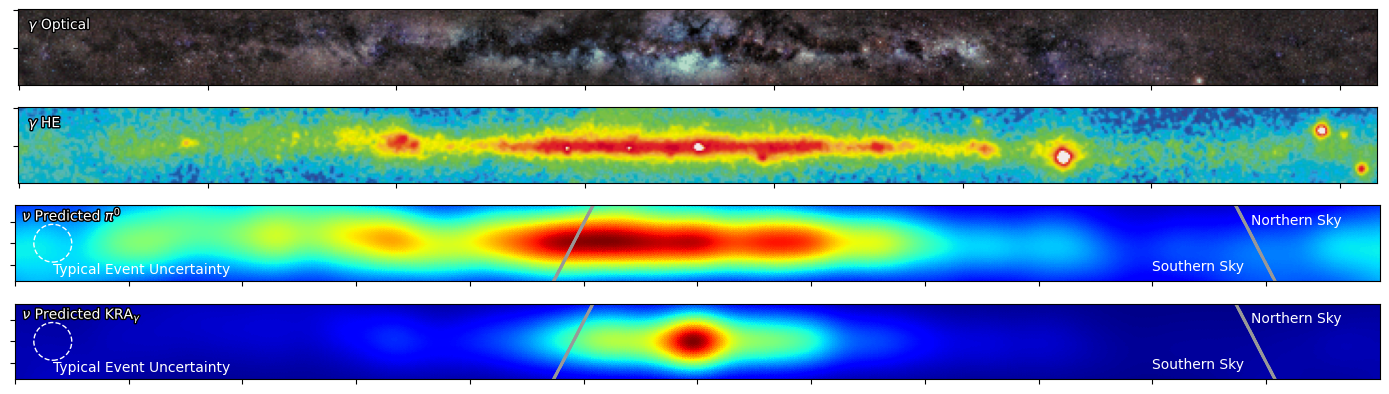

In [29]:
from scipy import stats
import matplotlib.patheffects as PathEffects
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1, ax2) = plt.subplots(4,1, figsize=(14,4))

ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'pi0'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1,
    skymap=template, cmap='jet',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted $\pi^0$' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax1.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax1.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)

template_str = 'kra5'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax2,
    skymap=template, cmap='jet',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax2.set_ylim(np.radians(-10),np.radians(10))
ax2.set_yticklabels([0])
txt = ax2.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted KRA$_\gamma$' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax2.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax2.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax2.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax2.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax2.grid(None)
plt.tight_layout()
plt.savefig('{}/template_galactic_both_models.png'.format(plot_dir))


bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/pytho

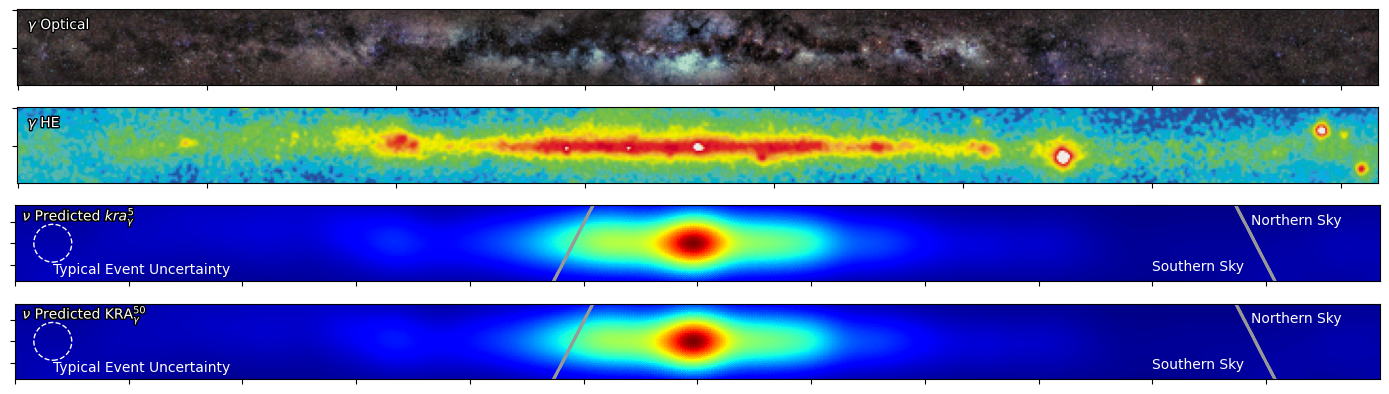

In [30]:
from scipy import stats
import matplotlib.patheffects as PathEffects
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1, ax2) = plt.subplots(4,1, figsize=(14,4))

ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'kra5'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1,
    skymap=template, cmap='jet',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted $kra_\gamma^5$' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax1.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax1.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)

template_str = 'kra50'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax2,
    skymap=template, cmap='jet',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax2.set_ylim(np.radians(-10),np.radians(10))
ax2.set_yticklabels([0])
txt = ax2.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted KRA$_\gamma^{50}$' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax2.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax2.text(np.radians(120), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax2.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax2.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax2.grid(None)
plt.tight_layout()
plt.savefig('{}/template_galactic_kra5_kra50.png'.format(plot_dir))


bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/pytho

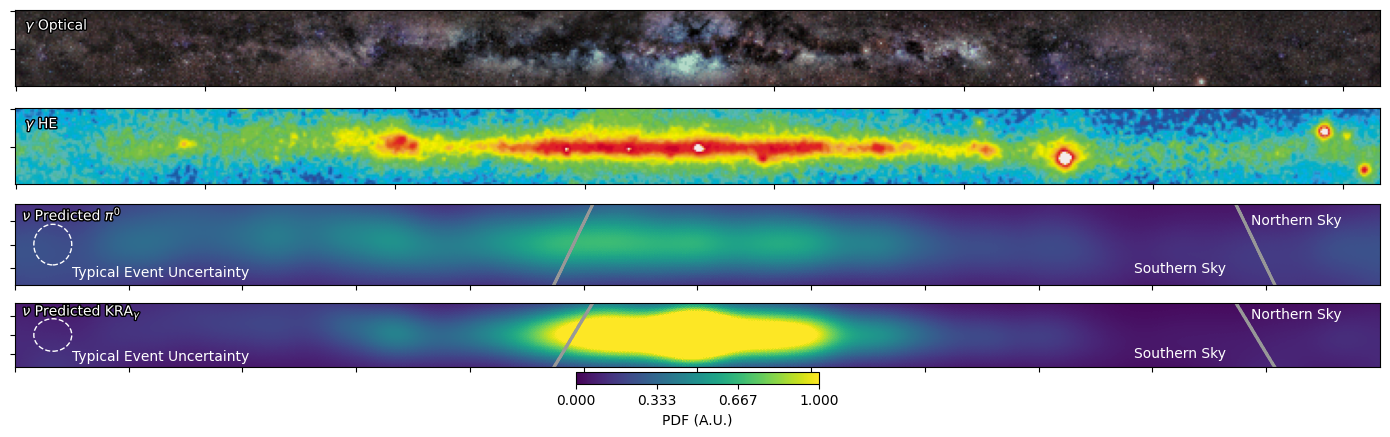

In [31]:
from scipy import stats
import matplotlib.patheffects as PathEffects
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1, ax2) = plt.subplots(4,1, figsize=(14,4.5))

ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'pi0'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1,vmin=0, vmax=1.,
    skymap=template, cmap='viridis',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted $\pi^0$' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(115), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax1.text(np.radians(-165), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax1.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)

template_str = 'kra5'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax2,
    skymap=template, cmap='viridis', n_cb_ticks= 4, vmin=0, vmax=1., cb_kw= {'pad' : 0.05},
    label=r'PDF (A.U.)'.format(template_str, smearing), 
    coord=coord,
)
ax2.set_ylim(np.radians(-10),np.radians(10))
ax2.set_yticklabels([0])
txt = ax2.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted KRA$_\gamma$' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax2.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax2.text(np.radians(115), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax2.text(np.radians(-165), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax2.add_patch(circle1)

template_plotter.draw_equator()
cb = template_plotter.cb
#plt.colorbar(cb, ax=ax3)
#template_plotter.cb.remove()
ax2.grid(None)
plt.tight_layout()
plt.savefig('{}/template_galactic_both_models_cb.png'.format(plot_dir))


bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/mnt/lfs7/user/ssclafani/software/extern

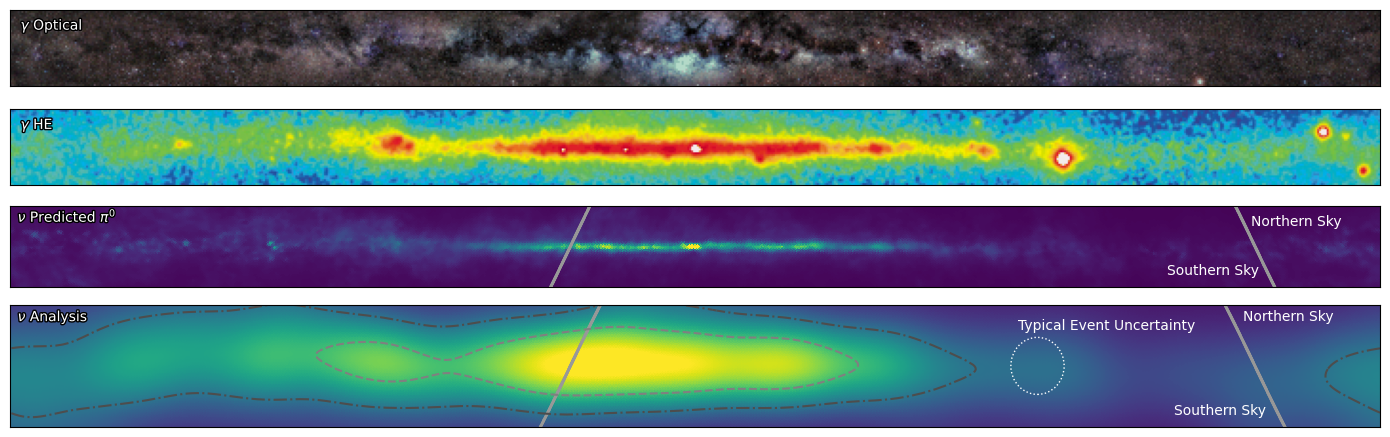

In [80]:
from scipy import stats
import matplotlib.patheffects as PathEffects
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1, ax2) = plt.subplots(4,1, figsize=(14,4.5), gridspec_kw={'height_ratios': [2,2,2,3]})


ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'pi0'
smearing = 0
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1, vmin=0, vmax=4,
    skymap=template, cmap='viridis',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted $\pi^0$' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(124), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

#circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
#ax1.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
#ax1.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)

template_str = 'pi0'
smearing = 7
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)

template_plotter = SkymapPlotter(fig=fig, ax=ax2, vmin=0, vmax=.5,
    skymap=template, cmap='viridis',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
smearing_deg = 7
q = 0.2
template_plotter.plot_template_contour('pi0', quantiles=[q, 0.5], color=['0.5', '0.3'], ls=['--', '-.'], smearing_deg=smearing_deg)


ax2.set_ylim(np.radians(-15),np.radians(15))
ax2.set_yticklabels([0])
txt = ax2.text(np.radians(-178), np.radians(11), r'$\nu$ Analysis' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax2.text(np.radians(144), np.radians(11), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax2.text(np.radians(126), np.radians(-12), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(90), 0), np.radians(7), color='w', fill=False, ls=':')
ax2.text(np.radians(85), np.radians(9), 'Typical Event Uncertainty', c='w')
ax2.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax2.grid(None)


#template_plotter.plot_template_contour('pi0', quantiles=[q], color=['0.2'], ls=['--'], smearing_deg=smearing_deg)
#skymap_plotter.plot_template_contour_points('pi0', level=q, color='0.2', smearing_deg=smearing_deg, delta=0.007)
#skymap_plotter.plot_template_contour_points('kra5', level=q, color='green', smearing_deg=smearing_deg, delta=0.004)

for ax in [ax0, ax0a, ax1, ax2]:
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()

plt.savefig('{}/template_galactic_pi0_effect_smearing_contour.png'.format(plot_dir))


bounds [-4.         -3.52941176 -3.05882353 -2.58823529 -2.11764706 -1.64705882
 -1.17647059 -0.70588235 -0.23529412  0.23529412  0.70588235  1.17647059
  1.64705882  2.11764706  2.58823529  3.05882353  3.52941176  4.        ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssclafani/.vens/py3_venv/lib/pytho

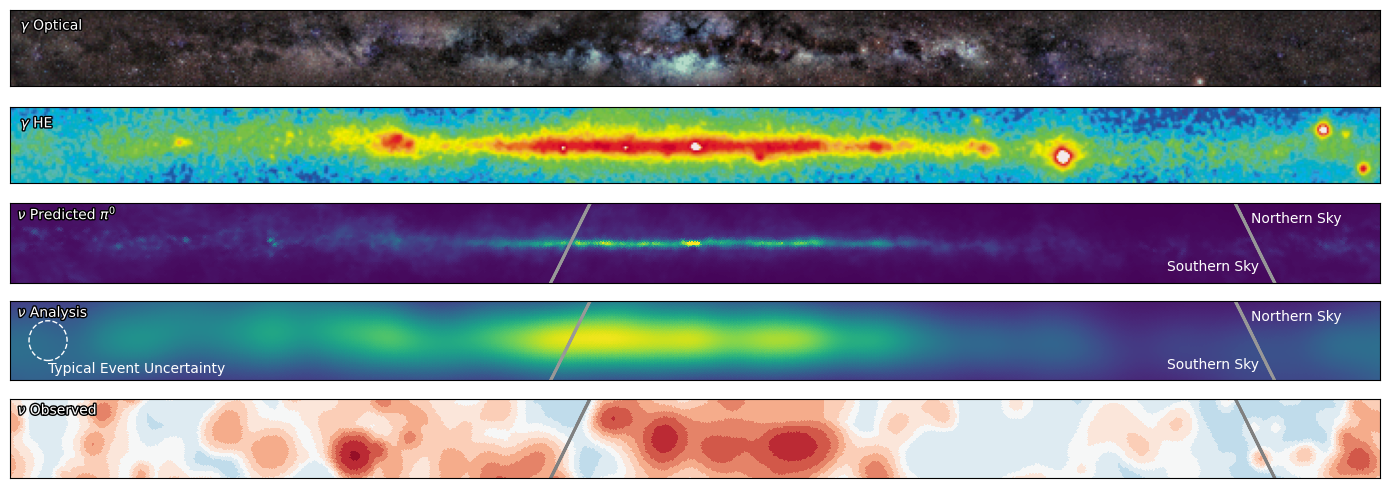

In [33]:
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

cmap = plt.cm.RdBu_r  # define the colormap
#cmap = plt
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-4, 4, 18)
print('bounds', bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax0, ax0a, ax1, ax2, ax3) = plt.subplots(5,1, figsize=(14,5))


ax0.imshow(gp_optical)
ax0.set_xticklabels([0])
ax0.set_yticklabels([0])

ax0a.imshow(gp_gamma.astype(np.uint8))
ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])

ax0a.set_xticklabels([0])
ax0a.set_yticklabels([0])
txt = ax0.text(5, 10, '$\gamma$ Optical' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
txt = ax0a.text(5, 10, '$\gamma$ HE' , color='w', alpha=1)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

template_str = 'pi0'
smearing = 0
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax1, vmin=0, vmax=4,
    skymap=template, cmap='viridis',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax1.set_ylim(np.radians(-10),np.radians(10))
ax1.set_yticklabels([0])
txt = ax1.text(np.radians(-178), np.radians(6), r'$\nu$ Predicted $\pi^0$' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax1.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax1.text(np.radians(124), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

#circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
#ax1.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
#ax1.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax1.grid(None)

template_str = 'pi0'
smearing = 5
coord = 'G'
template = get_smeared_template(template_str, smearing=smearing)
template_plotter = SkymapPlotter(fig=fig, ax=ax2,vmin=0, vmax=.7,
    skymap=template, cmap='viridis',
    label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
    coord=coord,
)
ax2.set_ylim(np.radians(-10),np.radians(10))
ax2.set_yticklabels([0])
txt = ax2.text(np.radians(-178), np.radians(6), r'$\nu$ Analysis' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

ax2.text(np.radians(146), np.radians(5), 'Northern Sky', size=10, c='w' , rotation_mode='default')
ax2.text(np.radians(124), np.radians(-7), 'Southern Sky', size=10, c='w', rotation_mode='default')

circle1 = plt.Circle((np.radians(-170), 0), np.radians(5), color='w', fill=False, ls='--')
ax2.text(np.radians(-170), np.radians(-8), 'Typical Event Uncertainty', c='w')
ax2.add_patch(circle1)

template_plotter.draw_equator()
template_plotter.cb.remove()
ax2.grid(None)

nsigma_plotter = SkymapPlotter(fig=fig, ax=ax3, 
                               skymap=ss_nsigmas, cmap=cmap, norm=norm, label=r'$n\cdot \sigma$', coord='G')
'''nsigma_plotter = SkymapPlotter(fig=fig, ax=ax2, 
                               skymap=ss_trial[0], cmap=cy.plotting.skymap_cmap, 
                               coord='G', vmin=0, vmax=5)'''
ax3.set_ylim(np.radians(-10), np.radians(10))
ax3.set_yticklabels([0])
nsigma_plotter.draw_equator(color='grey')
nsigma_plotter.cb.remove()
ax3.grid(None)

txt = ax3.text(np.radians(-178), np.radians(6), r'$\nu$ Observed' , color='w', alpha=1, )
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])


for ax in [ax0, ax0a, ax1, ax2, ax3]:
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()

plt.savefig('{}/template_galactic_pi0_effect_smearing_results.png'.format(plot_dir))


/mnt/lfs7/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)
/mnt/lfs7/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)
/mnt/lfs7/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions a

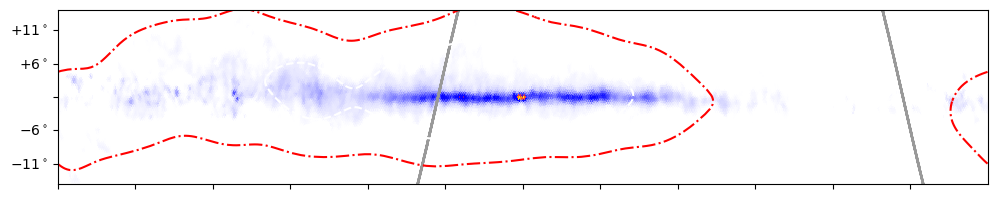

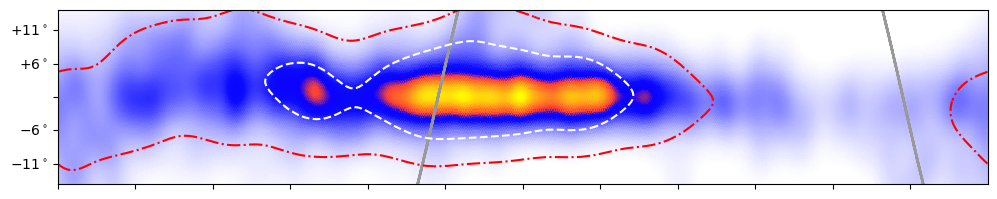

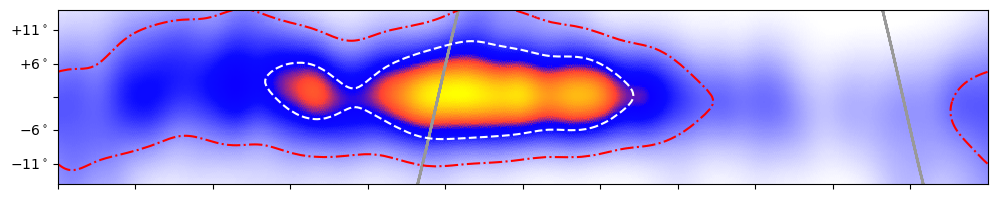

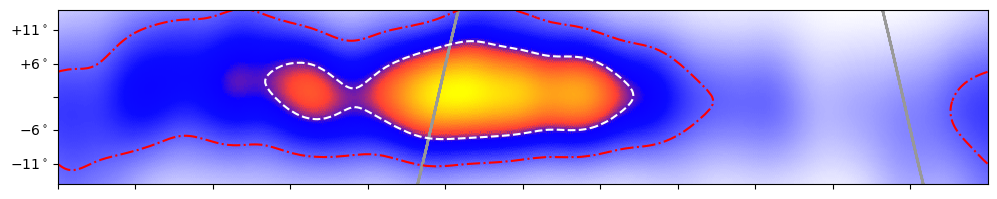

In [47]:
for template_str in ['pi0']:
    for smearing in [0., 2.5, 5, 7]:
        for coord in ['G']:
            template = get_smeared_template(template_str, smearing=smearing)
            fig, ax = plt.subplots(figsize=(12,3))
            skymap_plotter = SkymapPlotter(fig=fig, ax=ax,
                skymap=template, cmap=cy.plotting.skymap_cmap, 
                label=r'P({}) with {:1.0f}° smearing'.format(template_str, smearing), 
                coord=coord,
            )
            ax.set_ylim(np.radians(-15),np.radians(15))
            skymap_plotter.draw_equator()
            skymap_plotter.plot_template_contour('pi0', quantiles=[q, 0.5], color=['w', 'r'], ls=['--', '-.'], smearing_deg=smearing_deg)

            skymap_plotter.cb.remove()
            ax.grid(None)
            skymap_plotter.fig.savefig('{}/template_{}_smearing_{:1.1f}_{}.png'.format(
                plot_dir, template_str, smearing, coord))        